# Implementation of L-layer neural network used to classify cat images

## Setup

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
from collections import deque
from functions import *
%matplotlib inline

CE = CrossEntropy()
sigmoid = Sigmoid()
relu = Relu()

## Load data

In [2]:
with h5py.File("data/train_catvnoncat.h5", "r") as f:
    train_set_x_orig = f["train_set_x"][()]
    train_set_y = f["train_set_y"][()]

with h5py.File("data/test_catvnoncat.h5", "r") as f:
    test_set_x_orig = f["test_set_x"][()]
    test_set_y = f["test_set_y"][()]

In [3]:
print(f"{train_set_x_orig.shape = }")
print(f"{train_set_y.shape = }")
print(f"{test_set_x_orig.shape = }")
print(f"{test_set_y.shape = }")

train_set_x_orig.shape = (209, 64, 64, 3)
train_set_y.shape = (209,)
test_set_x_orig.shape = (50, 64, 64, 3)
test_set_y.shape = (50,)


y = 0


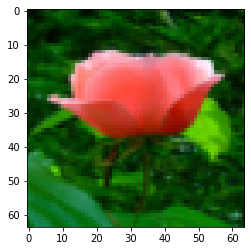

In [4]:
index = 3
plt.imshow(train_set_x_orig[index])
print(f"y = {train_set_y[index]}")

## Preprocess x datasets

After preprocessing data shoud be organised into four 2-dimensional arrays:
    
- `train_set_x`: (12288, 209),
- `test_set_x`: (12288, 50),
- `train_set_y`: (1, 209),
- `test_set_y`: (1, 50),

where each value in x is between 0 and 1 and each in y is either 0 or 1.

In [5]:
nx = train_set_x_orig.shape[0]
train_set_x = train_set_x_orig.reshape((nx,-1)).T # examples are columns
nx = test_set_x_orig.shape[0]
test_set_x = test_set_x_orig.reshape((nx,-1)).T
print(f"{train_set_x.shape = }")
print(f"{test_set_x.shape = }")

train_set_x.shape = (12288, 209)
test_set_x.shape = (12288, 50)


In [6]:
train_set_x = train_set_x/255
test_set_x = test_set_x/255

In [7]:
train_set_y = train_set_y.reshape(1,-1)
test_set_y = test_set_y.reshape(1,-1)

In [8]:
print(f"{train_set_y.shape = }")
print(f"{test_set_y.shape = }")

train_set_y.shape = (1, 209)
test_set_y.shape = (1, 50)


# Build model

Model has L hidden layers (customizable sizes) and uses ReLu activation function for all of them and then sigmoid for output layer.

### Building blocks

In [9]:
def initialize_parameters(layer_sizes: list, seed: int = 0) -> dict:
    """Returns dictionary containing weights W1, ... WL and biases b1, ... bL of L-layer neural network.
    Args:
        layers_sizes: list containing number of units in each layer [n0, ... nL]
        seed: number passed to np.random.seed before initialization of parameters
    """
    np.random.seed(seed)
    parameters = dict()
    for i in range(1,len(layer_sizes)):
        # W[l] has size n[l] x n[l-1] where n[0], ..., n[l] are sizes of layers starting from input layer X
        parameters[f"W{i}"] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * 0.01
        parameters[f"b{i}"] = np.zeros((layer_sizes[i],1))
    return parameters

In [10]:
def forward_prop(X: np.ndarray, parameters: dict[str, np.ndarray], activations: list[Function]) -> dict[str,np.ndarray]:
    """Returns dict containing computed values of A1, ... AL and Z1, ... ZL given current parameters and the data.
    
    Note: lists has L+1 elements and the first element (i=0) is a dummy element used to allow for use of the same indices
    corresponding to layers 1, ... L as in python list (0), 1, ... L.
    
    Args:
        X: array of size (nx, m) with training data
        parameters: dict containing keys W1, ..., WL, b1, ... bL for model's parameters
        activations: list with functions used as activation for each layer
    """
    if len(activations) != len(layer_sizes):
        raise ValueError(f"{len(layer_sizes) = } != {len(activations)}, they should be equal!")
    
    A_lst = [X]
    Z_lst = [np.nan] # dummy
    for i in range(1,len(activations)):
        Wi = parameters[f"W{i}"]
        bi = parameters[f"b{i}"]
        Zi = Wi @ A_lst[i-1] + bi
        Ai = activations[i](Zi)
        Z_lst.append(Zi)
        A_lst.append(Ai)
    return {"A_lst": A_lst, "Z_lst": Z_lst}

In [11]:
def backward_prop(
    Y: np.ndarray, parameters: dict, activations: list[Function],
    A_lst: list[np.ndarray], Z_lst: list[np.ndarray]) -> dict[str, np.ndarray]:
    """Implementation of backpropagation part of nn. Returns dict containing derivatives of parameters.
    
    Args:
        Y: array of size (1,m) with response variable 
        parameters: dict containing weights W1, ... WL and biases b1, ... bL
        activations: list of L+1 activation functions, where the last element is activation of output layer
        A_lst: list of cached A values computed during forward propagation
        Z_lst: list of cached Z values computed during forward propagation
    """
    m = Y.shape[1]
    L = len(activations)-1
    # TODO Change lists to deque?
    # Note: There are L+1 elements because i = 0 is dummy element that allows for use of the same indices
    # corresponding to layers 1 ... L as in python list (0,) 1, ... L.
    dA_lst = [np.nan]*(L+1)
    dZ_lst = [np.nan]*(L+1)
    dW_lst = [np.nan]*(L+1)
    db_lst= [np.nan]*(L+1)
    AL = A_lst[-1]
    assert np.array_equal(AL, A_lst[L]) # This is here to emphasise the difference in numbering
    dA_lst[-1] = activations[-1].get_derivative(AL) # TODO good args order? Maybe should pass Y as 
    for s in range(L):
        # Compute values in i-th layer for i = L, L-1, ... 1
        i = L-s
        dAi = dA_lst[i]
        Zi = Z_lst[i]
        dZi = dAi * activations[i].get_derivative(Zi)
        Wi = parameters[f"W{i}"]
        dWi = (1/m)*(dZi @ A_lst[i-1].T)
        dbi = (1/m)*np.sum(dZi, axis = 1, keepdims=True)
        dAi_minus_1 = Wi.T @ dZi
        # Assert shapes
        assert dZi.shape == Zi.shape
        assert dWi.shape == Wi.shape
        assert dbi.shape == parameters[f"b{i}"].shape
        assert dAi_minus_1.shape == A_lst[i-1].shape
        # Append computed values to relevant lists
        dZ_lst[i] = dZi
        dW_lst[i] = dWi
        db_lst[i] = dbi
        dA_lst[i-1] = dAi_minus_1

    # There should be as many gradients as hidden layers.
    assert len(db_lst) == L+1
    assert len(dW_lst) == L+1
    assert np.isnan(db_lst[0])
    assert np.isnan(dW_lst[0]) # check dummies
    # Combine lists into dictionary of gradients.
    grads = {}
    for i in range(1,L+1):
        grads[f"dW{i}"] = dW_lst[i]
        grads[f"db{i}"] = db_lst[i]
    assert len(parameters) == len(grads)
    return grads

In [12]:
def update_parameters(parameters: dict[str,np.ndarray], gradients:dict[str,np.ndarray], learning_rate: float):
    """Return updated parameters so that for each var = var - `learning_rate` * dvar.
    
    Implements basic version of gradient descent.
    Args:
        parameters: ...
        gradients: ...
        learning_rate: ...
    """
    new_parameters = dict()
    for var, value in parameters.items():
        dvar = gradients[f"d{var}"]
        assert dvar.shape == value.shape # arrays should have the same size as their gradients 
        new_parameters[var] = value - learning_rate * dvar
    return new_parameters

### Model

In [19]:
class NN:
    def __init__(self, layer_sizes: list[int], cost_function: Function, activations: list[Function]):
        """Initialize Neural Network without any fitted parameters.
        
        Args:
            layer_sizes: list containing number of units in each layer [n0, ... nL]
            cost_function: function of response Y_ and prediction Y (in this order)
            activations: list of L+1 functions used as activation for each layer
        """
        # TODO add assert for sizes
        self.layer_sizes = layer_sizes
        self.cost_function = cost_function
        self.activations = activations
        self.cost_history = []
        self.fitted_parameters = {}

    def fit(self, X: np.ndarray, Y: np.ndarray, alpha: float = 0.01, T: int = 100, print_cost: bool = True, seed: int = -1) -> None:
        """Fit model parameters to X and Y data.
        
        Args:
            X: array of features used in training
            Y: array of response variables
            alpha: value of learning rate in gradient descent
            T: number of iterations
            print_cost: prints cost after each iteration
            seed: seed passed to `initialize_parameters` (use value of -1 for random selection of seed)  
        """
        if seed == -1:
            seed = np.random.randint(100000)
        parameters = initialize_parameters(self.layer_sizes, seed)
        cost_history = []
        L = len(self.layer_sizes) - 1
        for i in tqdm(range(1,T+1), desc= "Fitting model parameters."):
            forward_results = forward_prop(X, parameters, self.activations)
            A_lst, Z_lst = forward_results["A_lst"], forward_results["Z_lst"]
            AL = A_lst[-1]
            cost_history.append(self.cost_function(AL,Y))
            if print_cost:
                print(f"{i}-th cost: {cost_history[-1]}")
            grads = backward_prop(Y, parameters, self.activations,A_lst, Z_lst)
            parameters = update_parameters(parameters, grads, alpha)

        # If everything is ok, save new parameters and cost history.
        self.fitted_parameters = parameters
        self.cost_history = np.array(cost_history)

    def predict(self, X: np.ndarray) -> np.ndarray:
        if len(self.fitted_parameters) == 0:
            raise Exception("Parameters are not fitted yet.")
        else:
            forward_results = forward_prop(X, self.fitted_parameters, self.activations)
            AL = forward_results["A_lst"][-1]
            return AL # This is Y_hat

    def plot_cost(self):
        """Show plot of most recent cost history."""
        plt.plot(self.cost_history)
        plt.title("Training cost history")
        plt.grid()
        plt.show()

Fitting model parameters.: 100%|██████████| 2500/2500 [00:17<00:00, 145.87it/s]


0.6931477726958


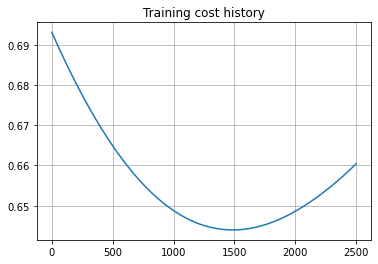

In [21]:
X,Y = train_set_x, train_set_y
layer_sizes = [12288, 20, 7, 5, 1]
L = len(layer_sizes)
activations = [*[relu]*(L-1), sigmoid]
model = NN(layer_sizes, CE, activations)
model.fit(X,Y, 0.0075, 2500, False, seed = 1)
print(model.cost_history[0])
model.plot_cost()

## Results

In [17]:
test_set_y.flatten().shape

(50,)

In [18]:
preds = model.predict(test_set_x)
preds_df = pd.DataFrame({"true": test_set_y.flatten(), "pred": preds.flatten()})
preds_df["good"] = np.equal(preds_df["true"], preds_df["pred"] > 0.5)
acc = preds_df["good"].mean()
print(f"Test set accuracy: {acc}")

Test set accuracy: 0.34
